RBF and MMDLoss classes are copied from https://github.com/yiftachbeer/mmd_loss_pytorch with some changes
Some inspiration from https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy
Autoencoder code from https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/ with changes to add dropout

In [22]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as trans

In [23]:
class RBF(nn.Module):

    def __init__(self, bandwidth=None): #bandwidth = sigma
        super().__init__()
        self.bandwidth_multipliers = torch.tensor([0.5, 1, 5, 10, 20, 40], dtype = torch.float32) 
        self.bandwidth = bandwidth

    def get_bandwidth(self):
        if self.bandwidth is None:
            return 1
        return self.bandwidth

    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2 
        return torch.exp(-0.5 * L2_distances[None, ...] / ((self.get_bandwidth() * self.bandwidth_multipliers)**2)[:, None, None]).sum(dim=0) - 6*torch.eye(len(X), dtype=torch.float32)

class MMDLoss(nn.Module):

    def __init__(self, kernel=RBF()):
        super().__init__()
        self.kernel = kernel

    def forward(self, X, Y):
        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        Y_size = Y.shape[0]
        XX = K[:X_size, :X_size].sum() / (X_size**2-X_size)
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].sum() / (Y_size**2-Y_size)
        return XX - 2 * XY + YY

Parameters:

In [24]:
N_batch = 500
N_epochs = 50
N_input = 50

N_batch_AE = 128
N_epochs_AE = 32

Load MNIST data:

In [25]:
trainds = torchvision.datasets.MNIST(root='./data', 
                                          train=True, 
                                          transform=trans.ToTensor(),  
                                          download=True)
trainldr = torch.utils.data.DataLoader(dataset=trainds, 
                                           batch_size=N_batch, 
                                           shuffle=True)
AE_trainldr = torch.utils.data.DataLoader(dataset=trainds, 
                                           batch_size=N_batch_AE, 
                                           shuffle=True)

Define and train autoencoder

In [26]:
np.random.seed(123)
torch.manual_seed(123)

class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Encoder
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Dropout(0.2),
            torch.nn.Linear(28 * 28, 400),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(400, 200),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(200, 100),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(50, 10),
            torch.nn.Sigmoid() 
        )
         
        # Decoder
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 28 * 28),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,enc):
        return self.decoder(enc)
    
autoencoder = AE()

# MSE Loss function
AE_loss_fn = torch.nn.MSELoss()
 
# Adam Optimizer with lr = 0.1
AE_optimizer = torch.optim.Adam(autoencoder.parameters(),
                             lr = 0.001)

for epoch in range(N_epochs_AE):
    for idx, (img, lbls) in enumerate(AE_trainldr): 
        img = img.reshape(-1, 28*28)
        
        reconstructed = autoencoder(img)

        loss = AE_loss_fn(img, reconstructed)
        AE_optimizer.zero_grad() 
        loss.backward() 
        AE_optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.056839704513549805
Finished epoch 1, latest loss 0.0550229474902153
Finished epoch 2, latest loss 0.05304902791976929
Finished epoch 3, latest loss 0.04836162179708481
Finished epoch 4, latest loss 0.04849005863070488
Finished epoch 5, latest loss 0.04633515328168869
Finished epoch 6, latest loss 0.04721422865986824
Finished epoch 7, latest loss 0.04352434724569321
Finished epoch 8, latest loss 0.046213556081056595
Finished epoch 9, latest loss 0.043090421706438065
Finished epoch 10, latest loss 0.04163723811507225
Finished epoch 11, latest loss 0.04212384670972824
Finished epoch 12, latest loss 0.041304316371679306
Finished epoch 13, latest loss 0.042114805430173874
Finished epoch 14, latest loss 0.04175011068582535
Finished epoch 15, latest loss 0.03966350480914116
Finished epoch 16, latest loss 0.04131152108311653
Finished epoch 17, latest loss 0.03882499784231186
Finished epoch 18, latest loss 0.038030873984098434
Finished epoch 19, latest loss 0.040

Autoencoder output:

5
tensor([[1.1737e-04, 1.2517e-04, 1.0467e-04, 1.0098e-04, 1.2988e-04, 1.1274e-04,
         1.0815e-04, 9.6696e-05, 1.1266e-04, 1.2116e-04, 1.0928e-04, 8.5892e-05,
         1.2554e-04, 1.0878e-04, 8.6836e-05, 9.4046e-05, 1.0665e-04, 1.1225e-04,
         1.2928e-04, 1.3856e-04, 1.3093e-04, 1.0510e-04, 1.1027e-04, 1.2611e-04,
         1.3244e-04, 1.1448e-04, 9.8739e-05, 8.4514e-05],
        [1.3814e-04, 9.2664e-05, 1.3704e-04, 8.4103e-05, 1.1505e-04, 1.2586e-04,
         6.8819e-05, 1.3422e-04, 7.4312e-05, 5.1097e-05, 3.6597e-05, 1.8617e-05,
         3.1490e-05, 4.5630e-05, 3.8950e-05, 1.1568e-04, 1.7148e-04, 1.0265e-04,
         1.1848e-04, 1.0220e-04, 1.1533e-04, 1.0908e-04, 1.5193e-04, 1.2569e-04,
         1.0053e-04, 1.0356e-04, 1.2315e-04, 8.8554e-05],
        [1.2039e-04, 1.0553e-04, 9.6598e-05, 8.3069e-05, 9.4714e-05, 1.1032e-04,
         7.1544e-05, 4.0225e-05, 1.0879e-05, 8.7193e-06, 2.8056e-06, 4.9605e-06,
         1.5400e-05, 4.3011e-05, 7.2861e-05, 1.7409e-04, 4.5472e-04, 7.4

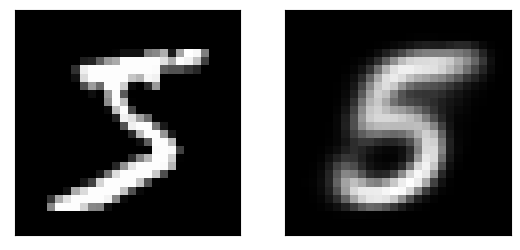

In [27]:
plt.gray()

ax = plt.subplot(1, 2, 1)
(img_data, lbl) = trainds[0]
img_data = img_data.reshape(28, 28)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(img_data)
print(lbl)

ax = plt.subplot(1, 2, 2)
img_reshaped = img_data.reshape(1,-1)
img_reconstructed = autoencoder(img_reshaped)
img_reconstructed = img_reconstructed.reshape(28,28)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(img_reconstructed.detach())

Define MMD network:

In [28]:
class network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(N_input, 200)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(200, 100)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(100, 100)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(100, 200)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(200, 10)
        self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.act_output(self.output(x))
        return x
    
model = network()

loss_fn = MMDLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

Train MMD netowrk:

In [29]:
np.random.seed(903)
torch.manual_seed(903)

for epoch in range(N_epochs):
    for idx, (x, lbls) in enumerate(trainldr):
        x = x.reshape(-1, 28*28) 
        x = autoencoder.encode(x) 

        x_input = np.random.uniform(-0.5,0.5,N_batch*N_input)
        x_input = torch.tensor(x_input, dtype=torch.float32).reshape(N_batch, N_input)

        x_output = model(x_input)

        loss = loss_fn(x, x_output)
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.09027576446533203
Finished epoch 1, latest loss 0.056578636169433594
Finished epoch 2, latest loss 0.041182518005371094
Finished epoch 3, latest loss 0.012941837310791016
Finished epoch 4, latest loss 0.027240276336669922
Finished epoch 5, latest loss 0.010041236877441406
Finished epoch 6, latest loss 0.006427764892578125
Finished epoch 7, latest loss 0.009685039520263672
Finished epoch 8, latest loss 0.005488395690917969
Finished epoch 9, latest loss 0.008006572723388672
Finished epoch 10, latest loss 0.004139423370361328
Finished epoch 11, latest loss 0.006170749664306641
Finished epoch 12, latest loss 0.0010142326354980469
Finished epoch 13, latest loss 0.0014929771423339844
Finished epoch 14, latest loss 0.0026988983154296875
Finished epoch 15, latest loss 0.00162506103515625
Finished epoch 16, latest loss -0.0006351470947265625
Finished epoch 17, latest loss 0.0034432411193847656
Finished epoch 18, latest loss 0.002810955047607422
Finished epoch 19,

Visualize model outputs:

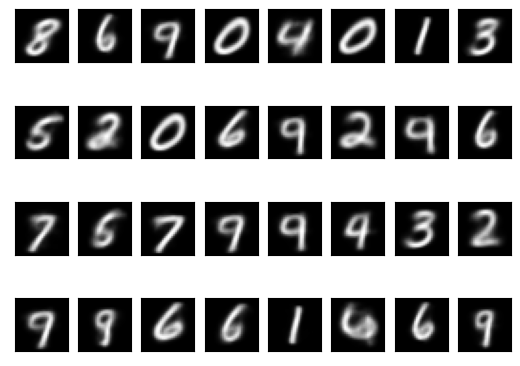

In [58]:
np.random.seed(0)

noises = []
plt.gray()
for r in range(4):
  for c in range(8):
    ax = plt.subplot(4, 8, r * 8 + c + 1)
    noise = np.random.uniform(-0.5,0.5,N_input)
    noise = torch.tensor(noise, dtype=torch.float32).reshape(1,-1)
    test = model(noise)
    image = autoencoder.decode(test)
    plt.imshow(image.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    noises.append(noise)
plt.show()

Plot nearest neighbours:

tensor([[0.0916]], grad_fn=<CdistBackward0>)
tensor([[0.0613]], grad_fn=<CdistBackward0>)
tensor([[0.0309]], grad_fn=<CdistBackward0>)
tensor([[0.0310]], grad_fn=<CdistBackward0>)


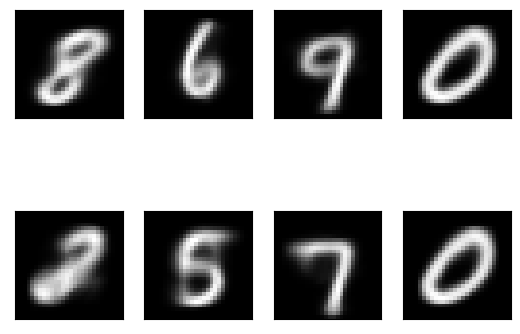

In [60]:
for i in range(4):
    ax = plt.subplot(2, 4, i+1)
    with torch.no_grad():
        test = model(noises[i])
    image = autoencoder.decode(test)
    plt.imshow(image.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    smallest = 0 #index such that MMD of image and train image is smallest using euclidean dist
    dist = float('inf')
    for j in range(len(trainds)):
        train = autoencoder.encode(trainds[j][0].reshape(-1,28*28))
        dist_new = torch.cdist(test,train)
        if dist_new < dist: 
            dist = dist_new
            smallest = j
    ax = plt.subplot(2, 4, 5+i)
    image = autoencoder(trainds[smallest][0].reshape(-1, 28*28))
    plt.imshow(image.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print(dist)
plt.show()